0:	learn: 0.4308955	test: 0.4310243	best: 0.4310243 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.0167770	test: 0.0175209	best: 0.0175209 (100)	total: 5.85s	remaining: 52.1s
200:	learn: 0.0164626	test: 0.0174291	best: 0.0174255 (197)	total: 11.4s	remaining: 45.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01742552529
bestIteration = 197

Shrink model to first 198 iterations.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117489
           1       0.86      0.64      0.74      1440

    accuracy                           0.99    118929
   macro avg       0.93      0.82      0.87    118929
weighted avg       0.99      0.99      0.99    118929



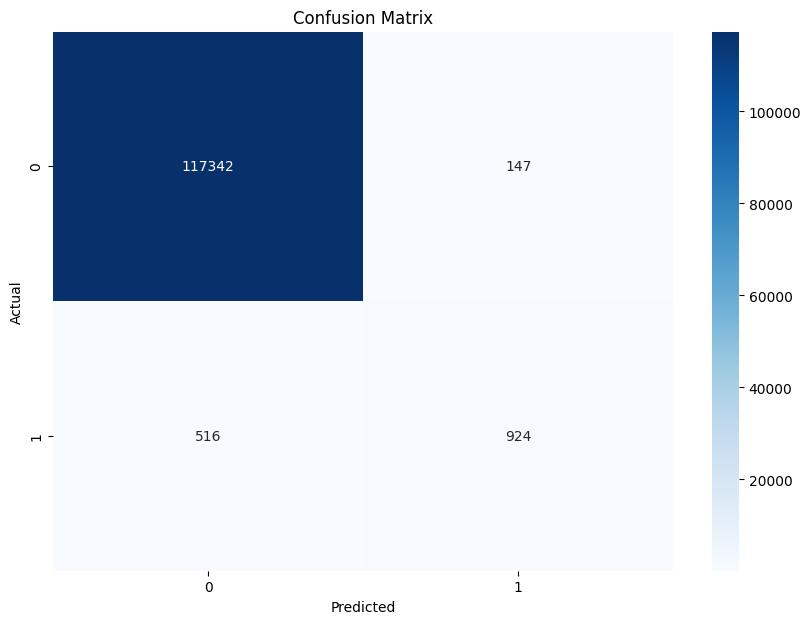

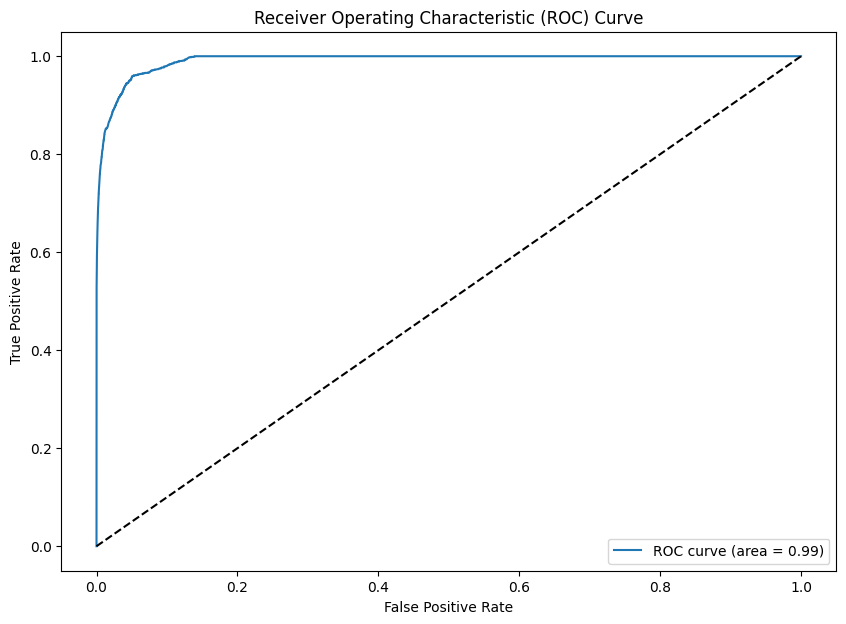

In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 전처리
data = pd.read_csv("data.csv").drop(columns=['step', 'zipcodeOri', 'zipMerchant', 'customer', 'merchant'])

# 라벨 인코딩
# le_customer = LabelEncoder()
# le_merchant = LabelEncoder()
le_category = LabelEncoder()
le_age = LabelEncoder()

# data['customer'] = le_customer.fit_transform(data['customer'])
# data['merchant'] = le_merchant.fit_transform(data['merchant'])
data['category'] = le_category.fit_transform(data['category'])
data['age'] = le_age.fit_transform(data['age'])
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# 학습 데이터와 타겟 분리
X = data.drop(columns=['fraud'])
y = data['fraud']

# train-validation 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 학습
cat_features = ['category']  # 범주형 변수 인덱스
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# 평가 지표 시각화
print(classification_report(y_valid, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

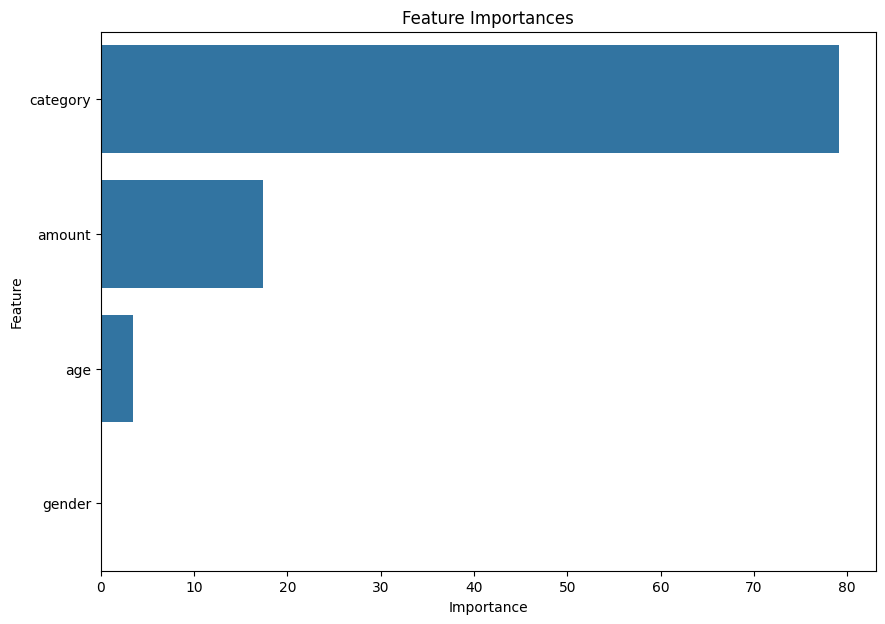

/home/gugu/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


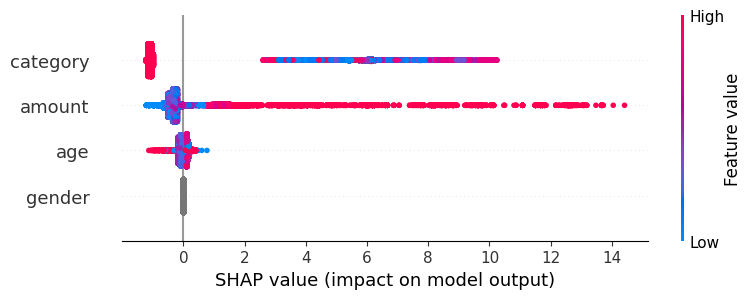

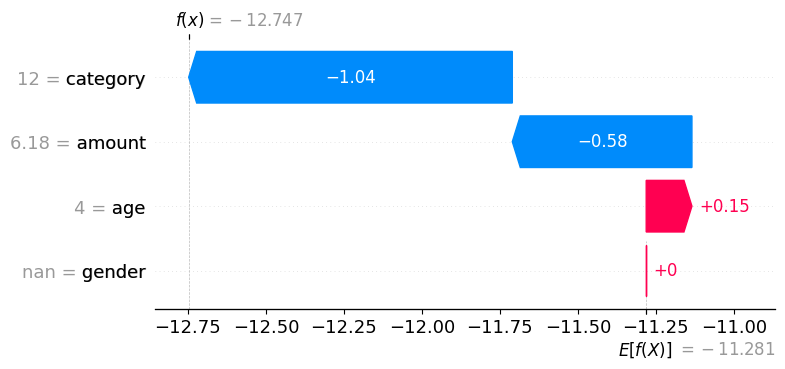

In [6]:
import shap

# 변수 중요도
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# SHAP 시각화
explainer = shap.Explainer(model)
shap_values = explainer(X_valid)

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_valid)
plt.show()

plt.figure(figsize=(10, 7))
shap.plots.waterfall(shap_values[0])
plt.show()

In [7]:
# 모델 저장
model.save_model("catboost_model.cbm")